# Estimate the density of samples

In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.tasks import two_moons
from flowjax.train import fit_to_data

In [2]:
# sample from the two moons distribution
n_samples = 10_000
rng = jr.key(0)
x = two_moons(rng, n_samples)
x = (x - x.mean(axis=0)) / x.std(axis=0)  # Standardize

In [3]:
# construct normalizing flow
key, subkey = jr.split(jr.key(0))
flow = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(x.shape[1])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

In [4]:
# train flow
key, subkey = jr.split(key)
flow, losses = fit_to_data(subkey, flow, x, learning_rate=1e-3)

 13%|█▎        | 13/100 [00:07<00:48,  1.80it/s, train=1.57, val=1.55 (Max patience reached)]


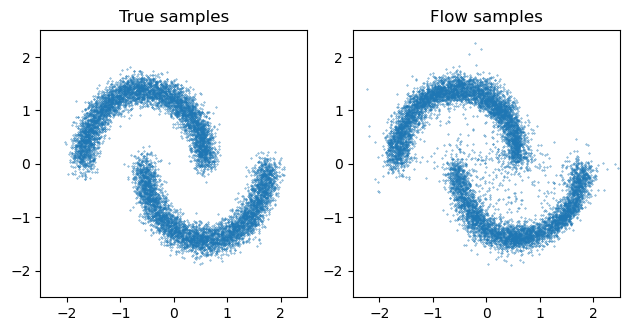

In [5]:
# sample from normalizing flow and plot against true samples
key, subkey = jr.split(key)
x_samples = flow.sample(subkey, (n_samples,))

fig, axs = plt.subplots(ncols=2)

axs[0].scatter(x[:, 0], x[:, 1], s=0.1)
axs[0].set_title("True samples")

axs[1].scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
axs[1].set_title("Flow samples")

lims = (-2.5, 2.5)
for ax in axs:
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()

In [6]:
# density estimation at certain points
point1 = jnp.array([0, 0])
point2 = jnp.array([0.5, -1.5])
print(flow.log_prob(point1))
print(flow.log_prob(point2))
print(flow.log_prob(jnp.array([point1, point2])))

-4.426611
-1.2572616
[-4.42661   -1.2572607]
